# Mafat Sat Challenge

### Imports

In [1]:
import math
import os
import sys
import torch
import torchvision
import utils
import engine
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.use('TKAgg', force=True)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from matplotlib.patches import Polygon
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm

c:\Users\Yanir Harel\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Playing with data

In [2]:
color_class = {'small_vehicle':'r', 'bus':'g', 'medium_vehicle':'b', 'large_vehicle':'c', 'double_trailer_truck':'m', 'container':'y',
'pylon':'k', 'small_aircraft':'purple', 'large_aircraft':'brown', 'small_vessel':'orange', 'medium_vessel':'pink', 'large_vessel':'olive',
               'heavy_equipment':'tab:olive'}

In [5]:
curr_image = '72_0_0'

In [78]:
metadata = pd.read_csv('metadata_train.csv')
metadata = metadata[metadata['Frame'] == curr_image]
print(metadata)

      Frame   AOI  Resolution  Sun_Elevation  Azimuth  Sun_Azimuth  \
740  72_0_0  13.0    1.061012      52.971639  227.284   234.263994   

     Hermetic_Small_Vehicle  
740                    True  


In [79]:
im = Image.open(rf'images\{curr_image}.tiff')
imarray = np.array(im)

In [80]:
columns_names = ['x1','y1','x2','y2','x3','y3','x4','y4' ,'category_id']

labels = pd.read_csv(rf'labelTxt\{curr_image}.txt', sep=" ", header=None, names=columns_names)

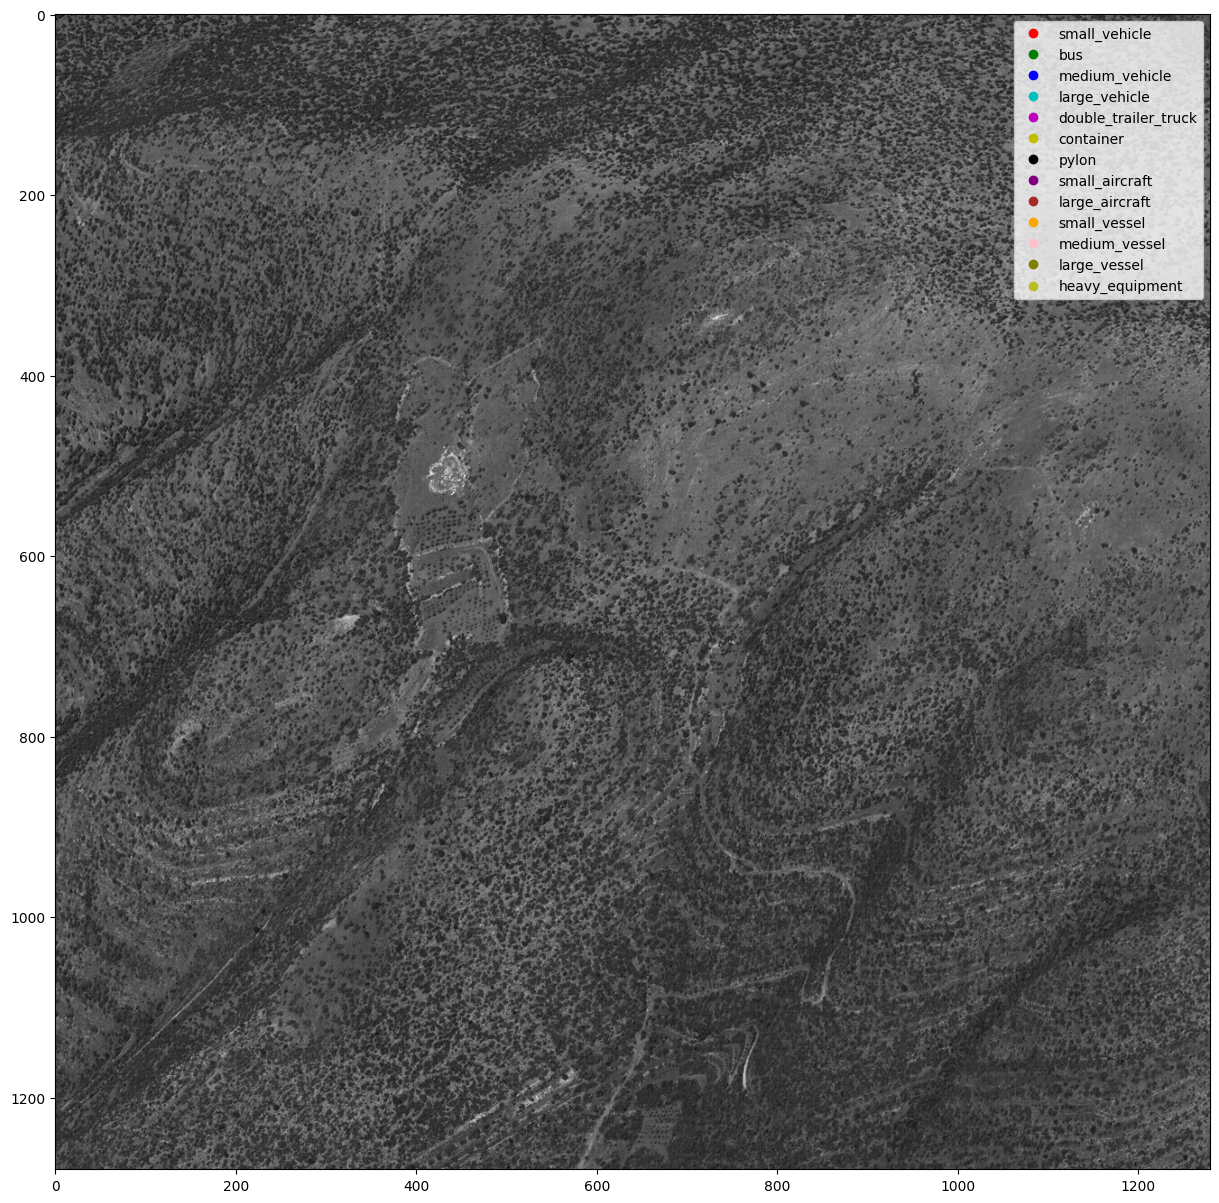

shape: (1280, 1280), dtype: uint16


In [88]:
fig, ax = plt.subplots(1, figsize=(15, 15))
ax.imshow(imarray, cmap='gray')
ax.grid(False)
for _, label in labels.iterrows():
  ax.add_patch(patches.Polygon(label[['x1','y1','x2','y2','x3','y3','x4','y4']].to_numpy().reshape((4, 2)), linewidth=1, edgecolor=color_class[label['category_id']], facecolor='none'))
ax.legend([plt.Line2D([0, 0], [0, 0], color=color, marker='o', linestyle='') for color in color_class.values()], color_class.keys())
plt.show()
print(f'shape: {imarray.shape}, dtype: {imarray.dtype}')

### Data Proccessing

In [2]:
image_dir_path = 'images'
label_dir_path = 'labelTxt'
metadata_file_path = 'metadata_train.csv'

#### Metadata extraction

Read the metadata from the file.

The metadata could potentially be used for kfolds corss-validation

In [3]:
metadata = pd.read_csv(metadata_file_path)

#### Labels extraction

Read the labels from the files.

Note that the image id is not written in the file but can be derived from the files name and added to the dataframe as the field `Frame`

The labels are a polygon inside the image boundires that has a `category_id` assined to it.

`category_id` will be canged to an enum starting form 1 because 0 is saved for `background` and saved in `class_id`

It can be inferred that pixels that are not assigned a value are `background`

In [4]:
columns_names = ['x1','y1','x2','y2','x3','y3','x4','y4' ,'category_id']
labels = pd.DataFrame(columns=columns_names + ['Frame'])

for label_file_name in os.listdir(label_dir_path):
   curr_labels = pd.read_csv(fr'{label_dir_path}\{label_file_name}', sep=" ", header=None, names=columns_names)
   curr_labels['Frame'] = label_file_name.split('.')[0]
   labels = pd.concat((labels, curr_labels))

In [5]:
labels['class_id'], categories = pd.factorize(labels['category_id'])

Visualize distribution

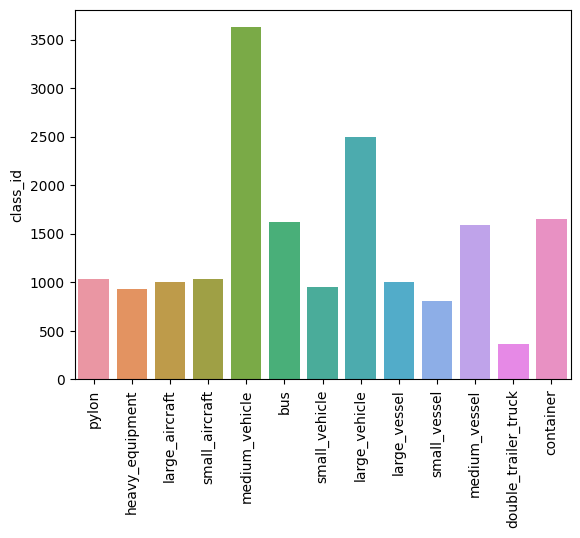

In [6]:
class_distribution = labels.groupby('class_id')['class_id'].count()

fig, ax = plt.subplots()

sns.barplot(x=categories, y=class_distribution)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

#### Calculate sample size

In [7]:
population_size = labels.shape[0]
confidence_level = 0.95
margin_of_error = 0.05
target_proportion = 0.5
z_score = norm.ppf(1 - (1 - confidence_level) / 2)

In [8]:
un_scaled_sample_size = z_score ** 2 * target_proportion * (1 - target_proportion) / margin_of_error ** 2

In [9]:
sample_size = math.ceil(un_scaled_sample_size / (1 + (un_scaled_sample_size - 1) / population_size))

#### Cross validation

Get balanced data samples

>potential undersampling

In [10]:
_, _, train_labels, test_labels = train_test_split(np.zeros(labels.shape[0]), labels, random_state=1, shuffle=True)

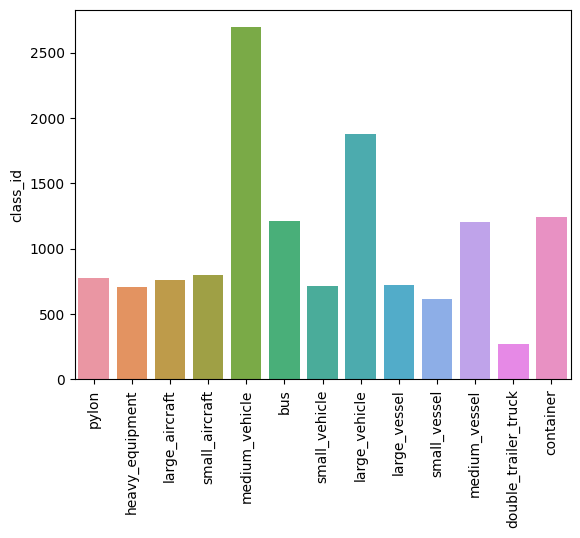

In [11]:
class_distribution = train_labels.groupby('class_id')['class_id'].count()

fig, ax = plt.subplots()

sns.barplot(x=categories, y=class_distribution)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

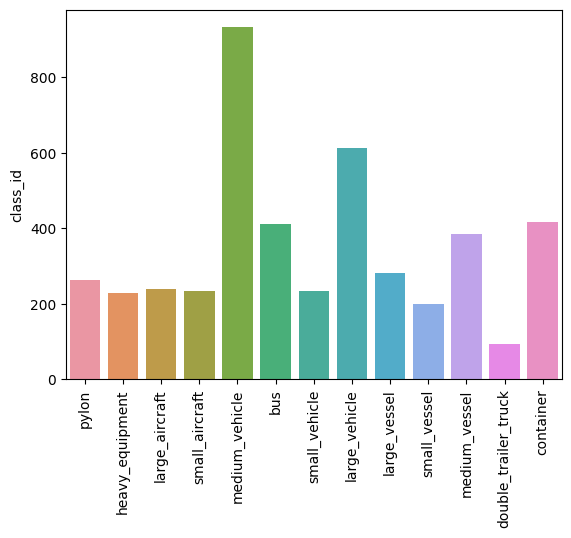

In [12]:
class_distribution = test_labels.groupby('class_id')['class_id'].count()

fig, ax = plt.subplots()

sns.barplot(x=categories, y=class_distribution)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

#### Images extraction

Images will be added via pytorch `torch.utils.data.Dataset` class

In [6]:
# images = np.empty((0, 1280))

# for image_file_name in os.listdir(image_dir_path):
#   im = Image.open(fr'{image_dir_path}\{image_file_name}')
#   images = np.concatenate((images, im), axis=0)

In [3]:
class MafatDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir, transforms) -> None:
        self.classes = {'small_vehicle': 1, 'bus': 2, 'medium_vehicle': 3, 'large_vehicle': 4, 'double_trailer_truck': 5, 'container': 6,
                        'pylon': 7, 'small_aircraft': 8, 'large_aircraft': 9, 'small_vessel': 10, 'medium_vessel': 11, 'large_vessel': 12,
                        'heavy_equipment': 13}
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transforms = transforms

        self.images_paths = np.array(os.listdir(images_dir))

        self.masks_paths = np.array(os.listdir(masks_dir))

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.images_dir, self.images_paths[idx]))

        columns_names = ['x1', 'y1', 'x2', 'y2',
                         'x3', 'y3', 'x4', 'y4', 'category_id']
        mask = pd.read_csv(os.path.join(
            self.masks_dir, self.masks_paths[idx]), sep=' ', header=None, names=columns_names)

        maxx = mask.filter(regex='x\d').max(axis=1)
        minx = mask.filter(regex='x\d').min(axis=1)
        maxy = mask.filter(regex='y\d').max(axis=1)
        miny = mask.filter(regex='y\d').min(axis=1)

        boxes = torch.as_tensor(
            np.c_[minx, miny, maxx, maxy], dtype=torch.float32)

        labels = torch.as_tensor(mask['category_id'].map(self.classes), dtype=torch.int64)

        image_id = torch.tensor([idx])

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd,
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return self.images_paths.shape[0]


#### Create a fastRcnn model

Replace the models last layer to finetune it to this datasets classes

In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

num_classes = 14 # plus one for the background

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=num_classes)

Transformer function from pytorch

In [10]:
def get_transform(train):
    transforms = []
    transforms.append(T.UInt16PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Iterate over dataset to see what the model expects during training

In [10]:
datatset = MafatDataset(image_dir_path, label_dir_path, get_transform(True))

In [11]:
sample = torch.utils.data.Subset(datatset, np.arange(10))

In [34]:
data_loader = torch.utils.data.DataLoader(
    sample, collate_fn=utils.collate_fn, batch_size=5, shuffle=True
)

In [35]:
images, targets = next(iter(data_loader))

In [31]:
len(targets)

5

In [17]:
images = list(image for image in images)
# targets = [{k: v[i] for k, v in targets.items()} for i in range(targets['boxes'].shape[0])]

In [21]:
output = model(images, targets)
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

#### Train the model on the dataset

Get device

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Use dataset and defined transformations

In [6]:
dataset = MafatDataset(images_dir=image_dir_path, masks_dir=label_dir_path, transforms=get_transform(True))
dataset_test = MafatDataset(images_dir=image_dir_path, masks_dir=label_dir_path, transforms=get_transform(True))

Split data to train and test

In [7]:
data_size = len(dataset)
test_size = math.ceil(data_size * 0.2)

indices = torch.randperm(data_size).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-test_size])
dataset_test = torch.utils.data.Subset(dataset, indices[-test_size:])

In [8]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

Move model to right device

In [11]:
model.to(device=device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Construct an optimizer

In [15]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params=params, lr=5e-3, momentum=0.9, weight_decay=5e-4)

Construct learning rate scheduler

In [16]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Train for 10 epochs

In [17]:
for epoch in range(10):
  engine.train_one_epoch(model, optimizer=optimizer, data_loader=data_loader, device=device, epoch=epoch, print_freq=10)
  lr_scheduler.step()
  engine.evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/583]  eta: 1:12:52  lr: 0.000014  loss: 3.0769 (3.0769)  loss_classifier: 2.6943 (2.6943)  loss_box_reg: 0.0394 (0.0394)  loss_objectness: 0.3341 (0.3341)  loss_rpn_box_reg: 0.0091 (0.0091)  time: 7.4994  data: 0.0811


KeyboardInterrupt: 